In [1]:
#Imports and dependencies
import os
from os.path import join
import torch
import torch.nn as nn
import math
import pandas as pd
import imageio
from skimage import img_as_ubyte
from itertools import product
from typing import List
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Textures
from pytorch3d.transforms import Rotate, Translate
from pytorch3d.renderer import (
    SfMPerspectiveCameras, OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights
)
from dataclasses import dataclass, field, asdict, astuple
import numpy as np
#Plotting Libs
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

from utils.shapes import Sphere, SphericalSpiral

['/home/alexis/Desktop/mono-eventcam', '/home/alexis/Desktop/mono-eventcam', '/home/alexis/anaconda3/envs/pytorch3d/lib/python37.zip', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/lib-dynload', '', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages', '/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/IPython/extensions', '/home/alexis/.ipython']


In [2]:
#Matplotlib config nums
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

#Set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device == "cuda:0": torch.cuda.set_device()

In [3]:
#Download a couple meshes to work with
!wget -P data/meshes https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
!wget -P data/meshes https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj

--2020-05-25 22:01:15--  https://dl.fbaipublicfiles.com/pytorch3d/data/dolphin/dolphin.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156763 (153K) [text/plain]
Saving to: ‘data/meshes/dolphin.obj.12’

dolphin.obj.12      100%[===================>] 153.09K   504KB/s    in 0.3s    

2020-05-25 22:01:16 (504 KB/s) - ‘data/meshes/dolphin.obj.12’ saved [156763/156763]

--2020-05-25 22:01:17--  https://dl.fbaipublicfiles.com/pytorch3d/data/teapot/teapot.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 2606:4700:10::6816:4b8e, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152595 (149K) [text/plain]
Saving to: ‘data/me

### Load Object

In [4]:
#Load the object without textures and materials
verts, faces_idx, _ = load_obj("data/meshes/teapot.obj")
faces = faces_idx.verts_idx

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:70: UserWarning:

Faces have invalid indices



### Create a renderer

In [5]:
cameras = SfMPerspectiveCameras(device=device)


# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, lights=lights)
)

### Create a reference image - look_at_view_transform

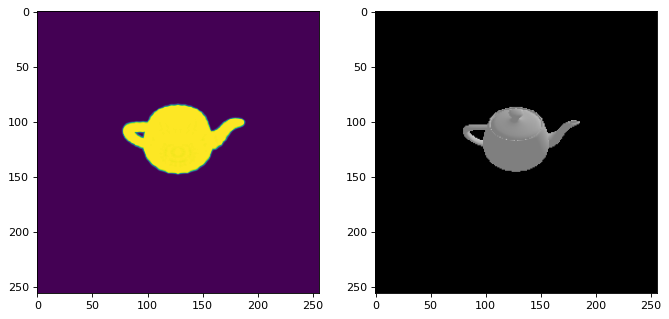

In [6]:
# Select the viewpoint using spherical angles  
distance = 3   # distance from camera to the object
elevation = 50.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

### Create a reference image - look_at_rotation

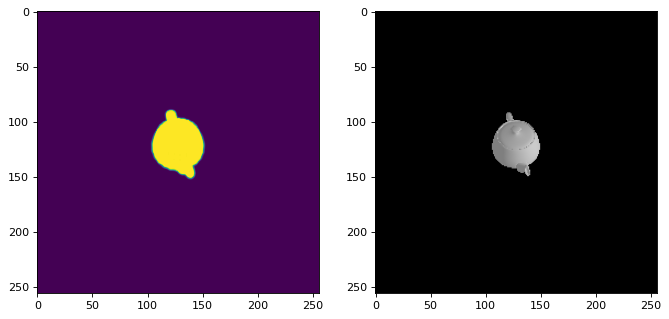

In [7]:
# Position of the camera in world coordinates
x = 2.1
y = 3.4
z = 0.5
cam_posn = torch.from_numpy(np.array([x, y, z], dtype=np.float32))
#at - position of the object in world coordinates 
#up - vector of up direction in world coordinates
R = look_at_rotation(cam_posn[None, :], device=device)
T = -torch.bmm(R.transpose(1,2), cam_posn[None, :, None])[:, :, 0]

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

In [11]:
Sphere(
    radius=2,
    num_points_theta = 1,
    num_points_phi = 30,
    theta_min = math.pi/2,
    theta_max = math.pi/2, 
    phi_max = math.pi).plot()

SphericalSpiral(
    a = 3,
    t_min = -2*math.pi,
    t_max=2*math.pi,
    num_points=100).plot()


### Camera Pose Trajectory and render

(-0.25582556672929946, -3.132959614350942e-17, 1.6877694141781463)
(-0.26133762547319683, -0.057524761344828895, 1.6436563180585806)
(-0.25422456356775675, -0.11761680768053064, 1.5931107328493332)
(-0.23355872414686268, -0.17754672622597217, 1.535080866730478)
(-0.1989803747119544, -0.23425780694695897, 1.468375785999878)
(-0.15081307903477736, -0.28446364371263455, 1.39167897057724)
(-0.09017570849843431, -0.324783549013039, 1.3035865224119187)
(-0.019080864763164562, -0.3519258427815128, 1.202682483408218)
(0.05949914874120376, -0.36292875163840155, 1.0876648241787792)
(0.14162940276273214, -0.35546299701879447, 0.9575322768123207)
(0.22251499647143344, -0.3281850667484581, 0.8118304040445141)
(0.29675654768546383, -0.28110273345349046, 0.6509319603758877)
(0.35879133265400565, -0.21587758218795342, 0.4762935264044953)
(0.40350809379856434, -0.13595770656401948, 0.29059976213347866)
(0.42695046436351225, -0.046433661234264303, 0.09770167377054195)
(0.42695046436351225, 0.04643366123

/home/alexis/anaconda3/envs/pytorch3d/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



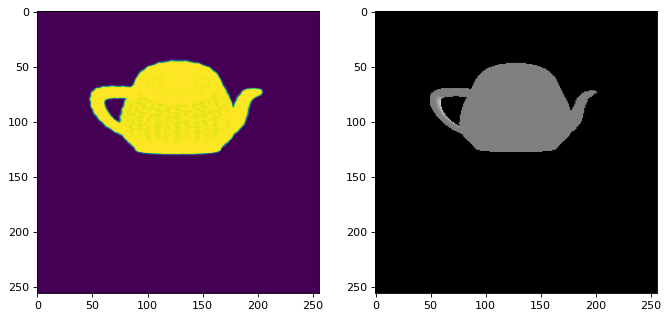

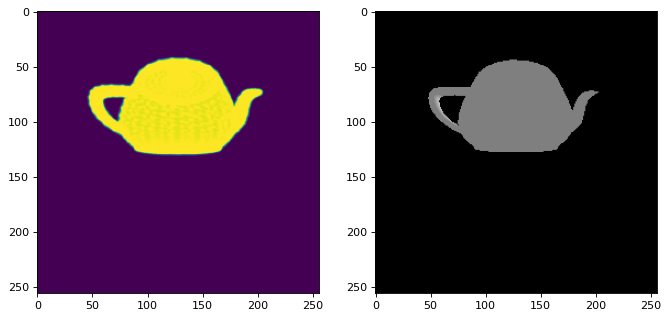

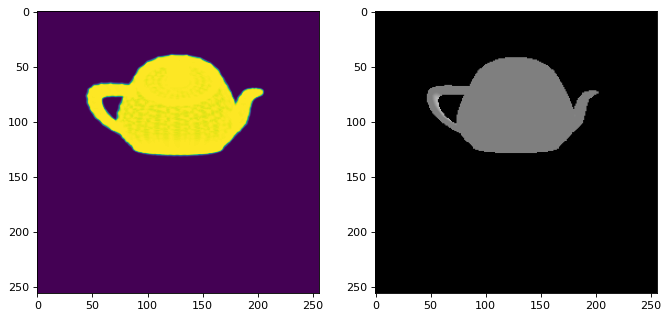

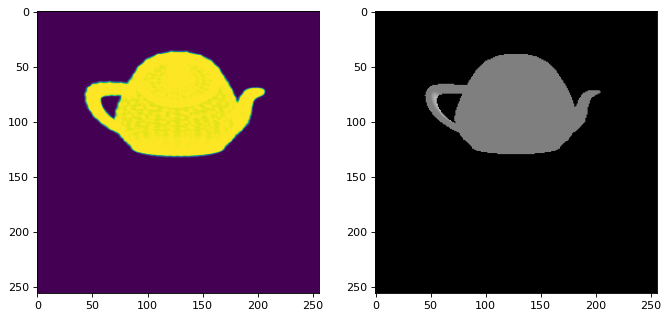

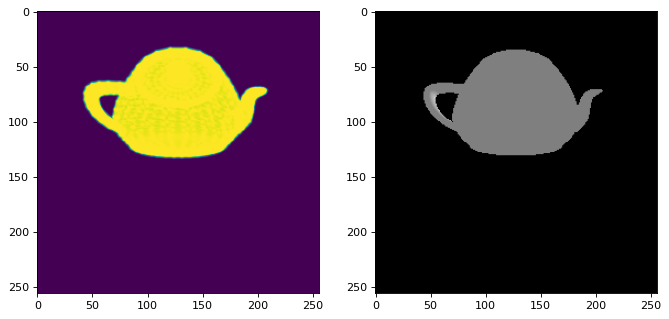

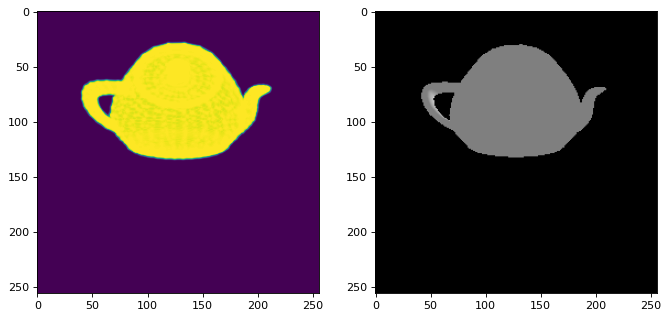

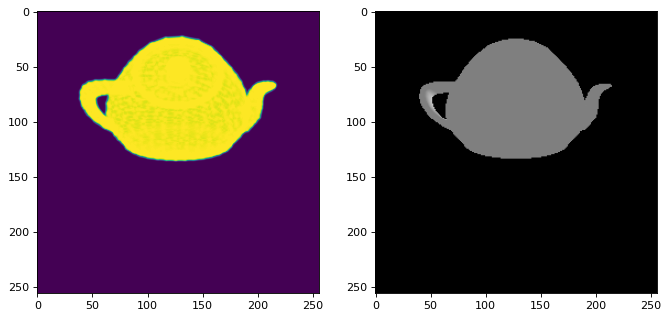

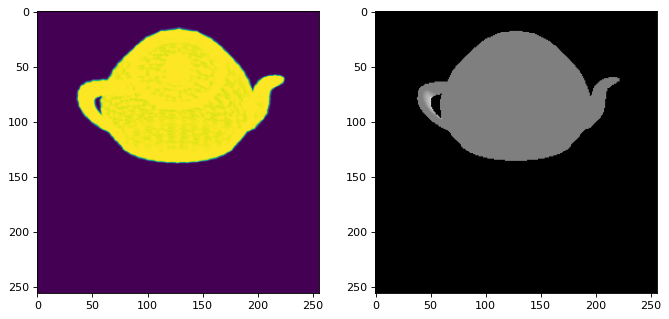

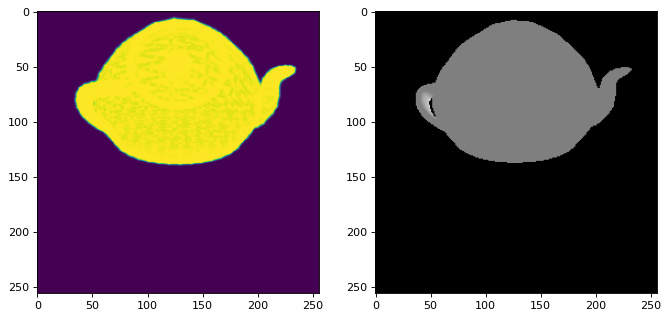

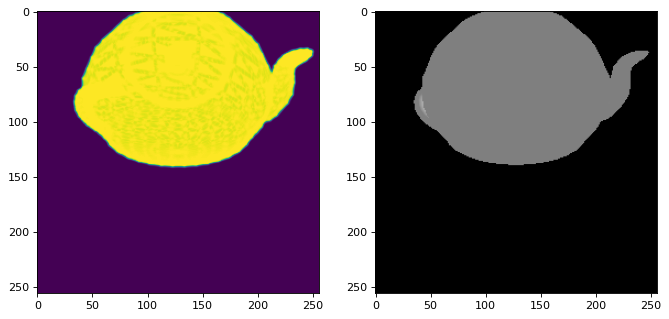

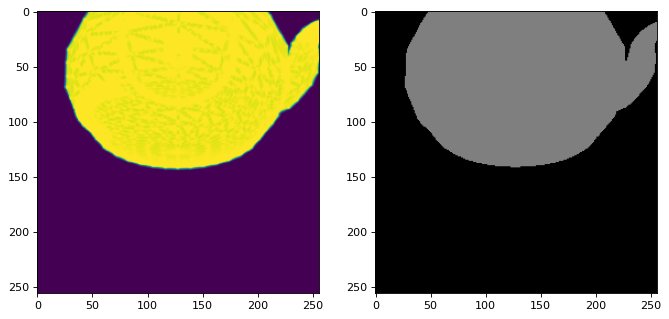

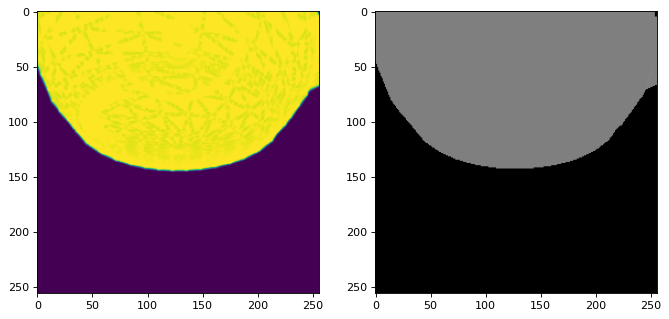

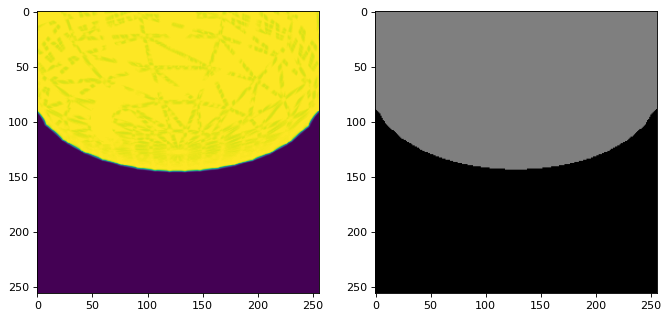

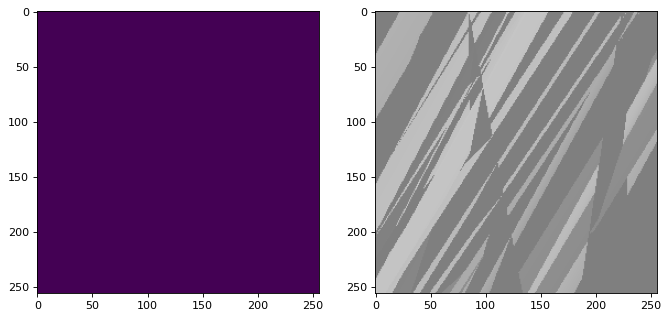

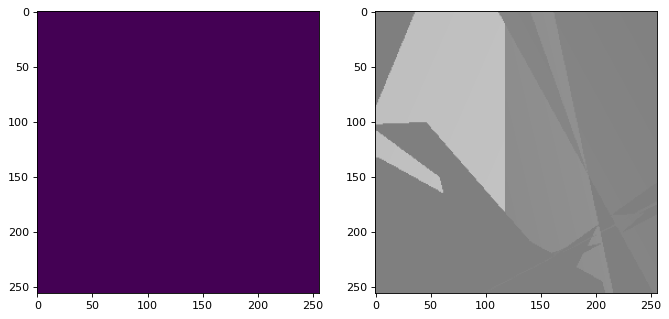

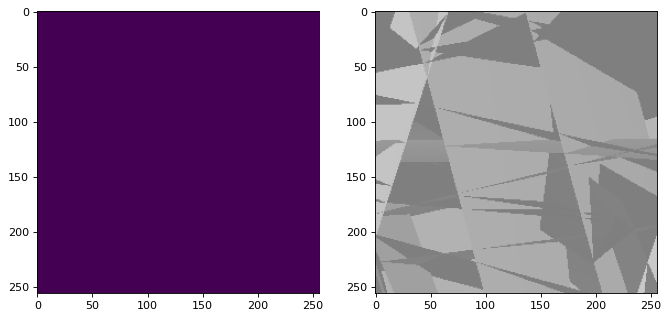

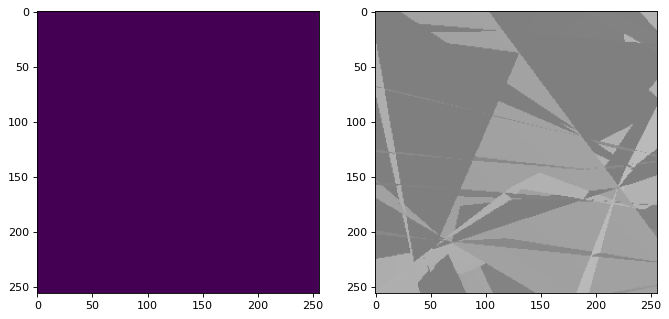

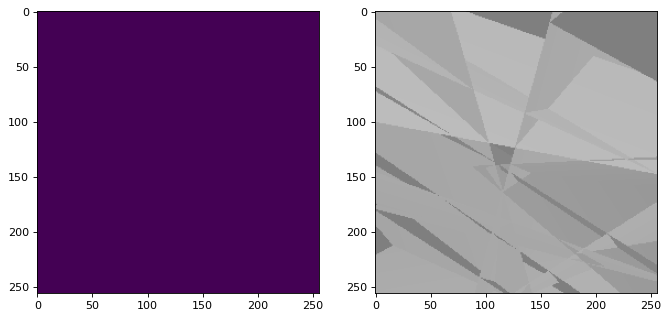

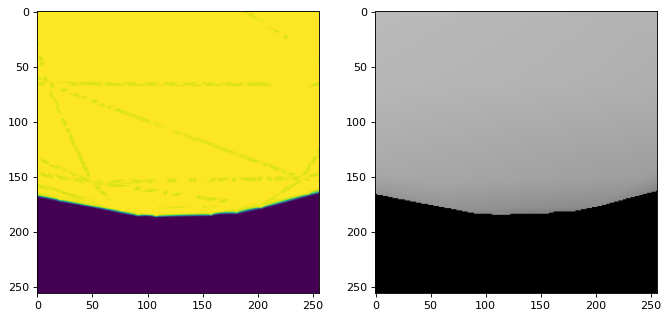

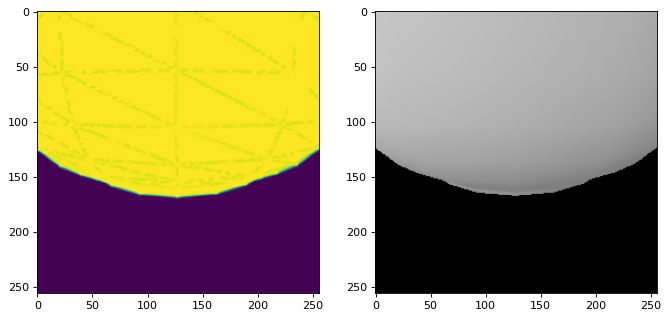

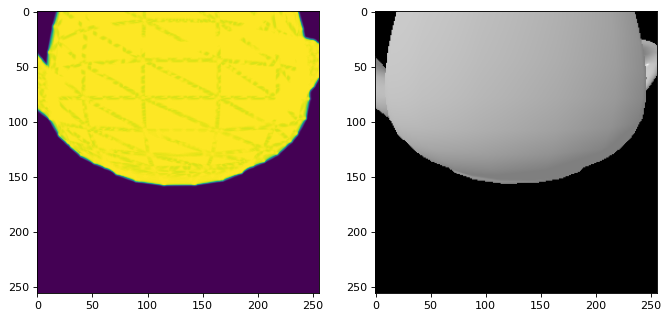

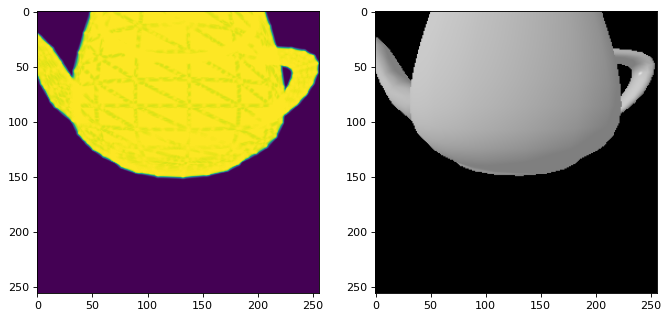

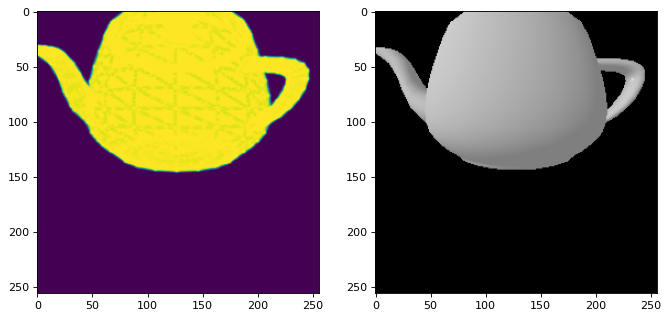

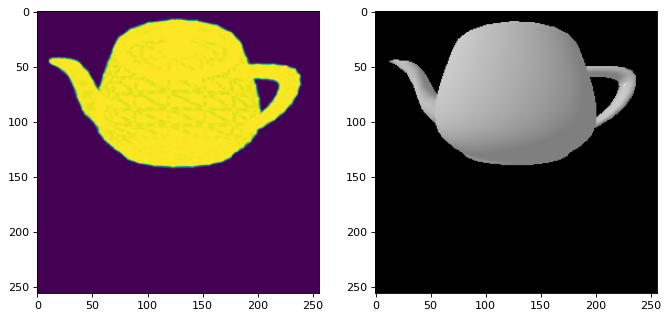

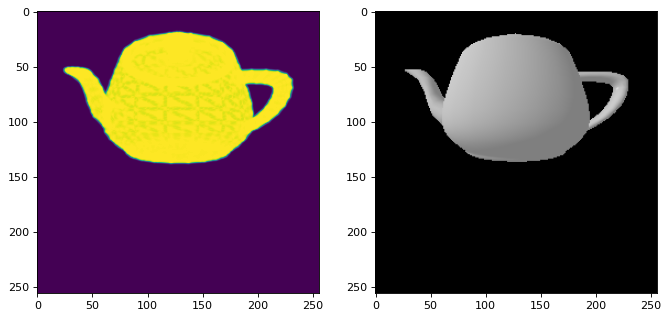

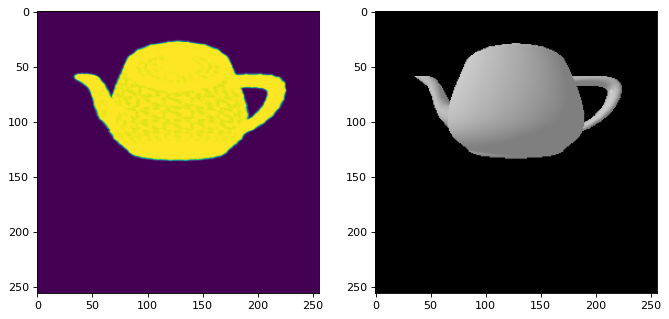

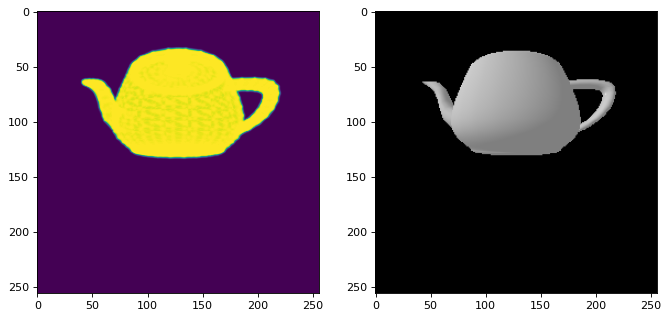

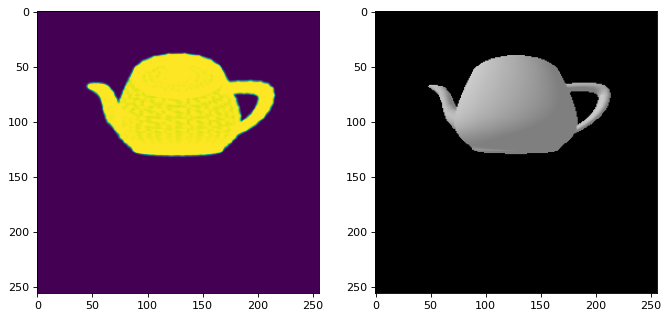

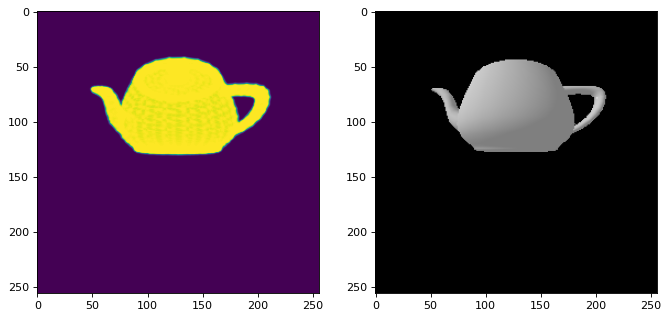

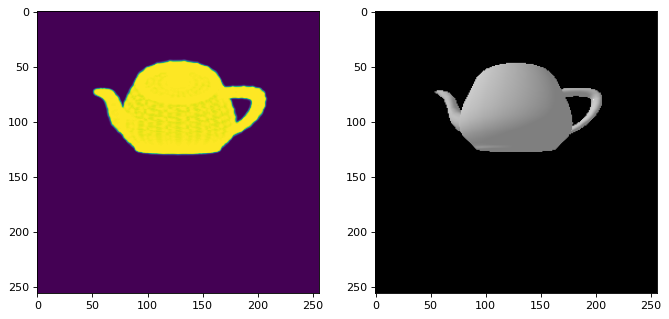

In [9]:
#Notes: benefit of having varying radiis for trajectory
#TODO: Move all the camera stuff to a dataclass

def cam_trajectory_rotation():
    """
    Input: 
    Return cameras from trajectory along a sphere
    """
    
    #sphere = Sphere(
    #    radius=2,
    #    num_points_theta = 1,
    #    num_points_phi = 30,
    #    theta_min = math.pi/2,
    #    theta_max = math.pi/2, 
    #    phi_max = math.pi)
    shape = SphericalSpiral(
        a = 3.1,
        t_min = -1*math.pi,
        t_max=1*math.pi,
        num_points=40)
    up = torch.tensor([[0,0,]])
    camera_poses = []
    for cp in shape._tuples:
        cp = torch.tensor(cp)
        R = look_at_rotation(cp[None, :], device=device)
        #To do fix mat2 problem here
        T = -torch.bmm(R.transpose(1,2), cp[None, :, None])[:, :, 0]
        camera_poses.append((R,T))
    return camera_poses

def cam_trajectory_transform(
    dist: float = 2.7,
    elev_range: list= [10, 50],
    azim_range: list= [-180, 180]):
    """
    Input
    Returns cameras from ranges of elevations and azimuths
    
    Not going to use this for now
    """
    
    elev = torch.linspace(elev_range[0], elev_range[1], batch_size)
    azim = torch.linspace(elev_range[0], elev_range[1], batch_size)
    cam_poses = []
    for e, a in elev, azim:
        R, T = look_at_view_transform(dist=dist, elev=e, azim=a)
        cam_poses.append((R,T))
    return cam_poses
    
def render_trajectory(cam_poses):
    
    output_folder = "./data/renders/"
    
    silhouette_output = join(output_folder, "camera_simulation_silhouette.gif")
    silhouette_writer = imageio.get_writer(silhouette_output, mode="I", duration=1)
    
    image_output = join(output_folder, "./camera_simulation_image.gif")
    image_writer = imageio.get_writer(image_output, mode="I", duration=1)
    
    # Render the teapot providing the values of R and T.
    for R,T in cam_poses:
        
        #gl_cam = OpenGLPerspectiveCameras(device=device, R=R, T=T)
        #sf_cam = SfMPerspectiveCameras(device=device, R=R, T=T)
        
        silhouette = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
        image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)
        
        silhouette = silhouette.cpu().numpy()
        image_ref = image_ref.cpu().numpy()
        
        #Plot figures
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(silhouette.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
        plt.grid(False)
        plt.subplot(1, 2, 2)
        plt.imshow(image_ref.squeeze())
        plt.grid(False)
        
        #Save to gif
        silhouette_byte = img_as_ubyte(silhouete.squeeze()[0,..., :3])
        silhouette_writer.append_data(silhouette_byte)
        image_byte = img_as_ubyte(image_ref.squeeze())
        image_writer.append_data(image_byte)
    
    silhouette_writer.close()
    image_writer.close()
    
cam_poses = cam_trajectory_rotation()
render_trajectory(cam_poses)

### Generate events from consecutive frames

In [ ]:
# tanh(a(I_2 - I_1))
for